In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from functools import reduce

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 60000) \
        .set('spark.network.timeout', 60000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab_1_var_5") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

directory_path = "data/"

file_list = [file for file in os.listdir(directory_path) if file.endswith(".csv")]

# Чтение файлов и создание DataFrame с явным указанием разделителя
dataframes = [spark.read.csv(os.path.join(directory_path, file), header=True, inferSchema=True, sep=';') for file in file_list]

# Объединение DataFrame в один
merged_dataframe = reduce(DataFrame.union, dataframes)

# Вывод первых строк объединенного DataFrame
merged_dataframe.show()

+-------------------+-------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------

In [3]:
merged_dataframe.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_01: double (nullable = true)
 |-- load_02: double (nullable = true)
 |-- load_03: double (nullable = true)
 |-- load_04: double (nullable = true)
 |-- load_05: double (nullable = true)
 |-- load_06: double (nullable = true)
 |-- load_07: double (nullable = true)
 |-- load_08: double (nullable = true)
 |-- load_09: double (nullable = true)
 |-- load_10: double (nullable = true)
 |-- load_11: double (nullable = true)
 |-- load_12: double (nullable = true)
 |-- load_13: double (nullable = true)
 |-- load_14: double (nullable = true)
 |-- load_15: double (nullable = true)
 |-- load_16: double (nullable = true)
 |-- load_17: double (nullable = true)
 |-- load_18: double (nullable = true)
 |-- load_19: double (nullable = true

In [4]:
# Удаление строк с пропущенными значениями
cleaned_dataframe = merged_dataframe.na.drop().filter(col("actual_consumption") >= 0)

In [5]:
# Рассчет квартилей
quartiles = cleaned_dataframe.stat.approxQuantile("actual_consumption", [0.25, 0.75], 0.0)

# Рассчет межквартильного размаха
IQR = quartiles[1] - quartiles[0]

# Определение границ для определения выбросов
lower_bound = quartiles[0] - 1.5 * IQR
upper_bound = quartiles[1] + 1.5 * IQR

# Удаление выбросов
outliers_removed_dataframe = cleaned_dataframe.filter((col("actual_consumption") >= lower_bound) & (col("actual_consumption") <= upper_bound))

In [6]:
# Расчет статистических показателей
statistics_summary = cleaned_dataframe.describe()
# Вывод сводной статистики
statistics_summary.show()

+-------+-----------------+-----------------+-------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----

array([[<Axes: title={'center': 'actual_consumption'}>]], dtype=object)

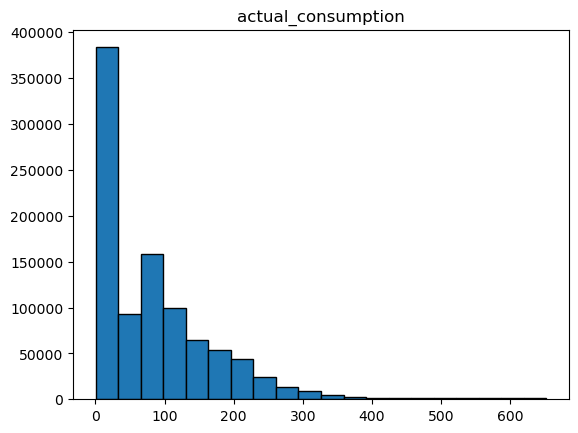

In [7]:
import matplotlib.pyplot as plt

# Преобразование Spark DataFrame в Pandas DataFrame для визуализации
pandas_df = cleaned_dataframe.select("actual_consumption").toPandas()

# Построение гистограммы
pandas_df.hist(column="actual_consumption", bins=20, grid=False, edgecolor="black")
plt.show()

In [8]:
# Выбор двух столбцов для расчета корреляции
selected_columns = ["actual_consumption", "actual_pv"]
correlation_matrix = cleaned_dataframe.select(selected_columns).toPandas().corr()

# Вывод результатов
print(correlation_matrix)

                    actual_consumption  actual_pv
actual_consumption            1.000000   0.473257
actual_pv                     0.473257   1.000000
